In [1]:
#Importing Packages
from tqdm import tqdm
import numpy as np
from tinygp import kernels, GaussianProcess
from scipy.stats import multivariate_normal
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import arviz as az
from src.model_fitting_functions import run_inference
from src.examples_functions import tinygp_model,tinygp_2process_model
from src.examples_functions import realisations_2process
from src.examples_functions import singleprocess_posterior_predictive_realisations
from src.examples_functions import plot_underlying_data,plotting_output_2process

plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.4

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
jax.config.update("jax_enable_x64", True)

In [7]:
def lima_method(ox,odata,nx,npr,nppr):
    # npr = num_parameter_realisations
    # nppr = num_posterior_pred_realisations 
    mcmc = run_inference(
        tinygp_model, rng_key_, 1000, 2000, ox,data=odata,noise=onoise)
    idata = az.from_numpyro(mcmc)
    realisations = singleprocess_posterior_predictive_realisations(
        nx,ox,idata,onoise,npr,nppr)
    return(realisations)

def step_by_step_method(ox,odata,cx,cdata,cnoise,nx,npr,nppr):
    mcmc_climate = run_inference(
        tinygp_model, rng_key_, 1000, 2000, cx,data=cdata,noise=cnoise)
    idata_climate = az.from_numpyro(mcmc_climate)

    climate_realisations = singleprocess_posterior_predictive_realisations(
        ox,cx,idata_climate,cnoise,npr,nppr)
    bdata_realisations = climate_realisations - odata
    bdata_expecation = bdata_realisations.mean(axis=(0,1))
    bnoise = bdata_realisations.std(axis=(0,1)).mean()

    mcmc_bias = run_inference(
        tinygp_model, rng_key_, 1000, 2000, ox,data=bdata_expecation,noise=bnoise)
    idata_bias = az.from_numpyro(mcmc_bias)
    bias_realisations = singleprocess_posterior_predictive_realisations(
        nx,ox,idata_bias,bnoise,npr,nppr)
    
    climate_realisations = singleprocess_posterior_predictive_realisations(
        nx,cx,idata_climate,cnoise,npr,nppr)
    truth_realisations = climate_realisations - bias_realisations

    truth_realisations = truth_realisations.reshape(-1,truth_realisations.shape[-1])
    bias_realisations = bias_realisations.reshape(-1,bias_realisations.shape[-1])

    return(truth_realisations,bias_realisations)

In [8]:
X = jnp.arange(0,100,0.1)

sample: 100%|██████████| 3000/3000 [00:49<00:00, 60.04it/s, 15 steps of size 4.41e-01. acc. prob=0.82] 



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
     bkern_var      3.43      1.95      2.96      0.78      6.13   1185.36      1.00
  blengthscale      7.90      3.32      7.47      2.99     12.27    715.64      1.00
         bmean     -1.07      0.79     -1.09     -2.42      0.10   1276.94      1.00
      kern_var      1.68      0.48      1.63      0.90      2.39    778.16      1.00
   lengthscale      2.90      0.08      2.90      2.77      3.02    789.17      1.00
          mean      1.16      0.36      1.17      0.58      1.74    834.58      1.00

Number of divergences: 52
Time Taken: 50.57937915623188


sample: 100%|██████████| 3000/3000 [00:26<00:00, 112.53it/s, 7 steps of size 4.77e-01. acc. prob=0.94] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      3.27      0.93      3.12      1.92      4.67    888.62      1.00
  lengthscale      3.02      0.07      3.02      2.91      3.14    986.17      1.00
         mean     -0.03      0.48     -0.02     -0.94      0.67   1244.65      1.00

Number of divergences: 0
Time Taken: 27.013801362365484


sample: 100%|██████████| 3000/3000 [00:05<00:00, 536.49it/s, 1 steps of size 5.64e-01. acc. prob=0.93]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      2.24      1.08      2.01      0.85      3.62    758.05      1.00
  lengthscale      3.53      0.52      3.51      2.65      4.37   1074.80      1.00
         mean     -1.38      0.48     -1.39     -2.15     -0.58   1386.77      1.00

Number of divergences: 0
Time Taken: 5.88235417380929


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


Text(0.5, 1.0, 'Step-by-step Method')

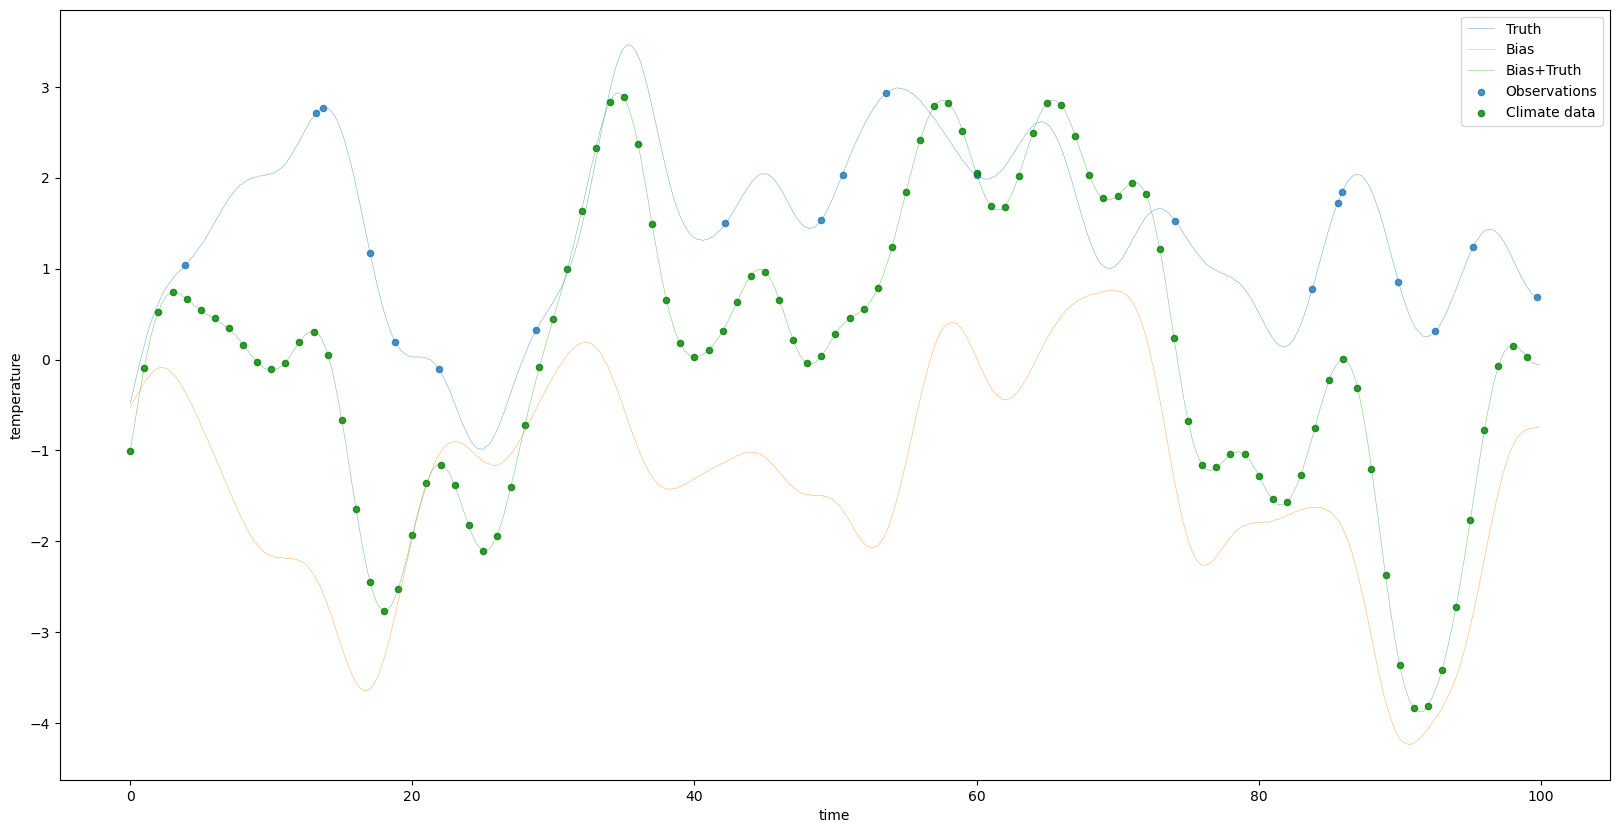

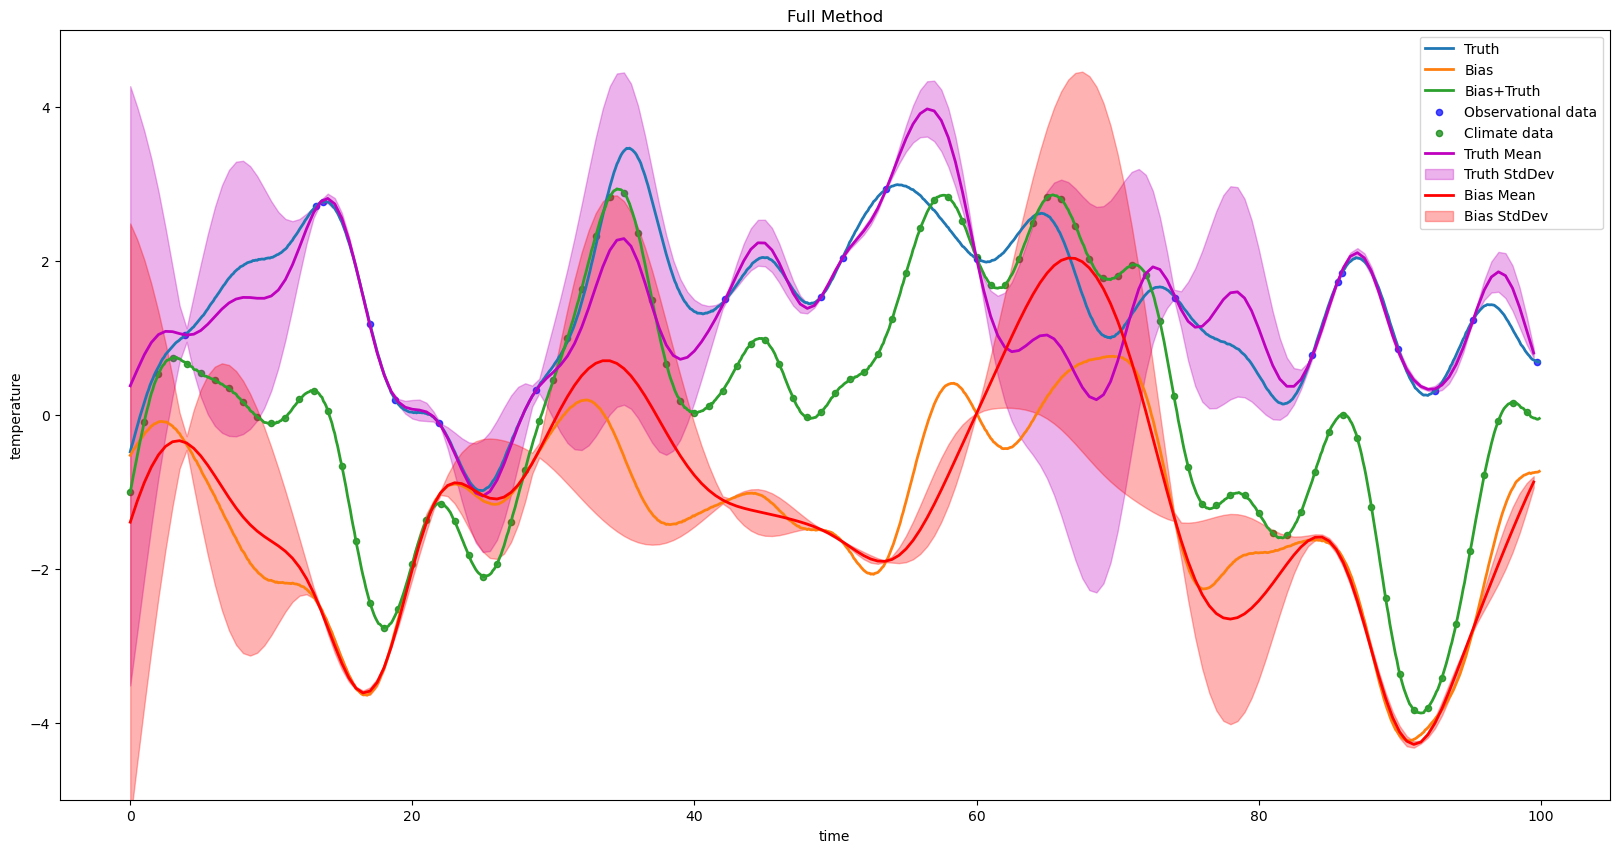

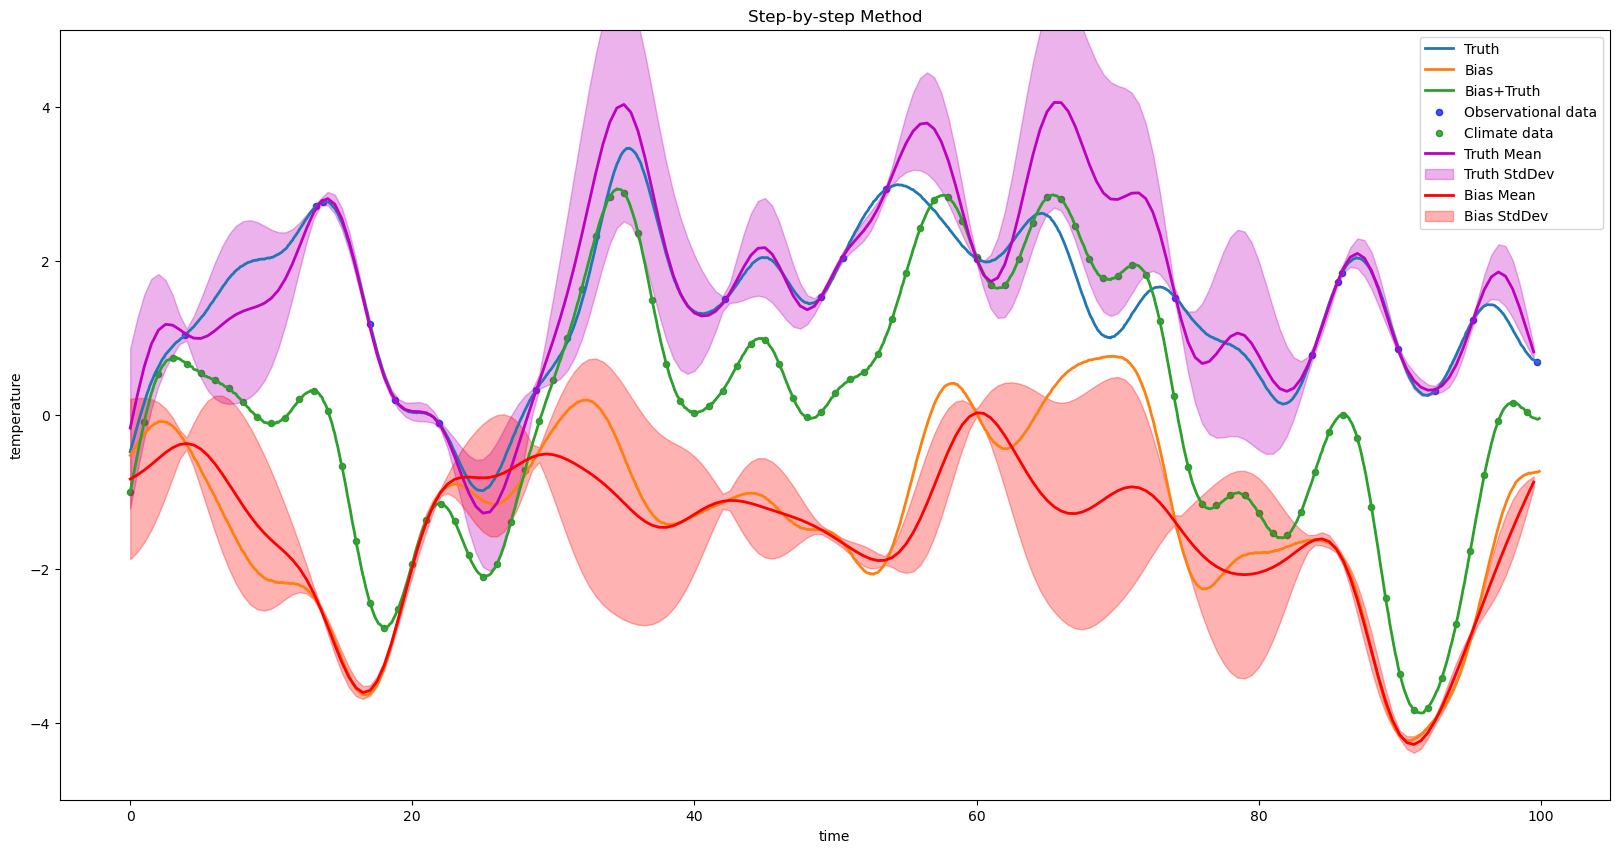

In [13]:
# Scenario: Similar Lengthscales, Sparse Observations
onoise=1e-5
bnoise=1e-5
cnoise=1e-5
jitter=1e-5

GP = GaussianProcess(1 * kernels.ExpSquared(3),X,diag=onoise,mean=1.0)
Y = GP.sample(rng_key)

GP2 = GaussianProcess(1 * kernels.ExpSquared(3),X,diag=bnoise,mean=-1.0)
rng_key, rng_key_ = random.split(rng_key)
Y2 = GP2.sample(rng_key)

cx = X[::10] 
cdata = (Y+Y2)[::10] 
osample = np.random.choice(range(X.size), size=int(0.2*cx.size), replace=False)
ox = X[osample]
odata = Y[osample]

plot_underlying_data(X,Y,Y2,ox,odata,cx,cdata,fs=(20,10),ms=20)

mcmc_2process = run_inference(
    tinygp_2process_model, rng_key_, 1000, 2000,
    cx,ox=ox,cdata=cdata,odata=odata,onoise=onoise,cnoise=cnoise)
idata_2process = az.from_numpyro(mcmc_2process)
nx = X[::5] # locations where predictions will be made

truth_realisations,bias_realisations = realisations_2process(
    nx,ox,cx,odata,cdata,idata_2process,onoise,cnoise,jitter,20,20)

plotting_output_2process(X,Y,Y2,ox,odata,cx,cdata,
                         truth_realisations,bias_realisations,nx,
                         fs=(20,10),ms=20,ylims=[-5,5])
plt.title('Full Method')

sbs_truth_realisations,sbs_bias_realisations = step_by_step_method(
    ox,odata,cx,cdata,cnoise,nx,20,20)

plotting_output_2process(X,Y,Y2,ox,odata,cx,cdata,
                         sbs_truth_realisations,sbs_bias_realisations,nx,
                         fs=(20,10),ms=20,ylims=[-5,5])
plt.title('Step-by-step Method')

sample: 100%|██████████| 3000/3000 [00:45<00:00, 65.30it/s, 7 steps of size 4.74e-01. acc. prob=0.91]  



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
     bkern_var      3.43      1.92      3.00      0.77      6.06   1694.54      1.00
  blengthscale      9.03      3.03      8.90      3.79     13.36   1438.48      1.00
         bmean     -0.92      0.87     -0.97     -2.41      0.38   1825.36      1.00
      kern_var      1.20      0.22      1.18      0.84      1.53   1650.95      1.00
   lengthscale      1.03      0.03      1.03      0.98      1.09   1429.25      1.00
          mean      0.68      0.50      0.68     -0.17      1.46   1926.17      1.00

Number of divergences: 0
Time Taken: 46.70145510882139


sample: 100%|██████████| 3000/3000 [00:24<00:00, 122.73it/s, 7 steps of size 5.07e-01. acc. prob=0.93] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      2.26      0.45      2.20      1.58      2.91   1081.81      1.00
  lengthscale      1.15      0.04      1.15      1.09      1.21   1170.70      1.00
         mean     -0.62      0.24     -0.62     -1.04     -0.25   1334.69      1.00

Number of divergences: 0
Time Taken: 24.806016579270363


sample: 100%|██████████| 3000/3000 [00:05<00:00, 532.43it/s, 7 steps of size 6.35e-01. acc. prob=0.93]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      3.96      2.62      3.39      0.37      7.62   1283.43      1.00
  lengthscale      9.96      3.75      9.45      3.66     14.88   1515.16      1.00
         mean     -0.64      1.20     -0.64     -2.50      1.41   1332.49      1.00

Number of divergences: 1
Time Taken: 5.934985589236021


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


Text(0.5, 1.0, 'Step-by-step Method')

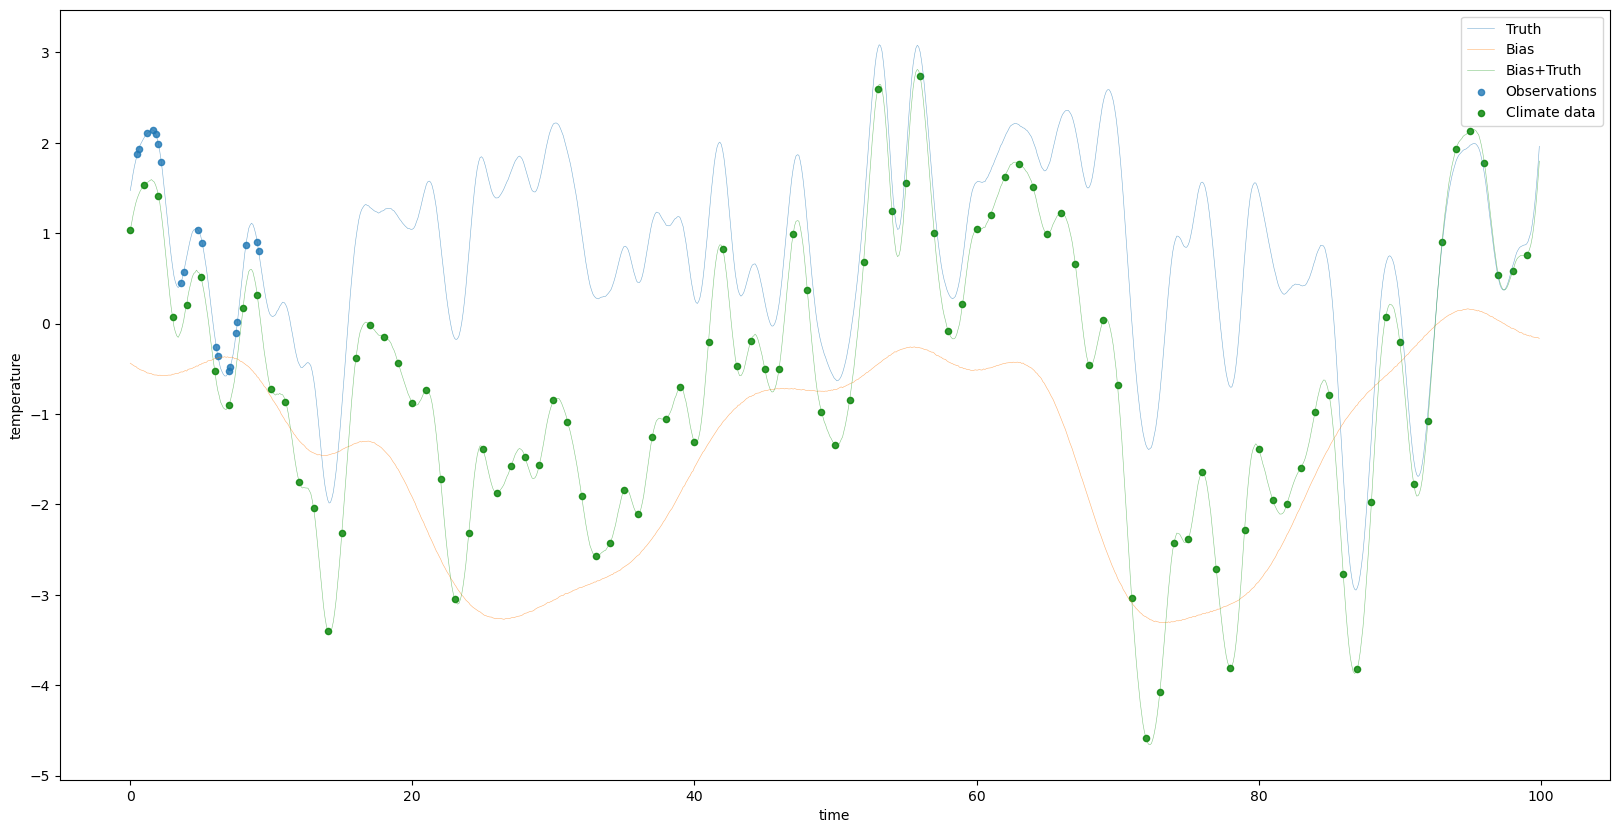

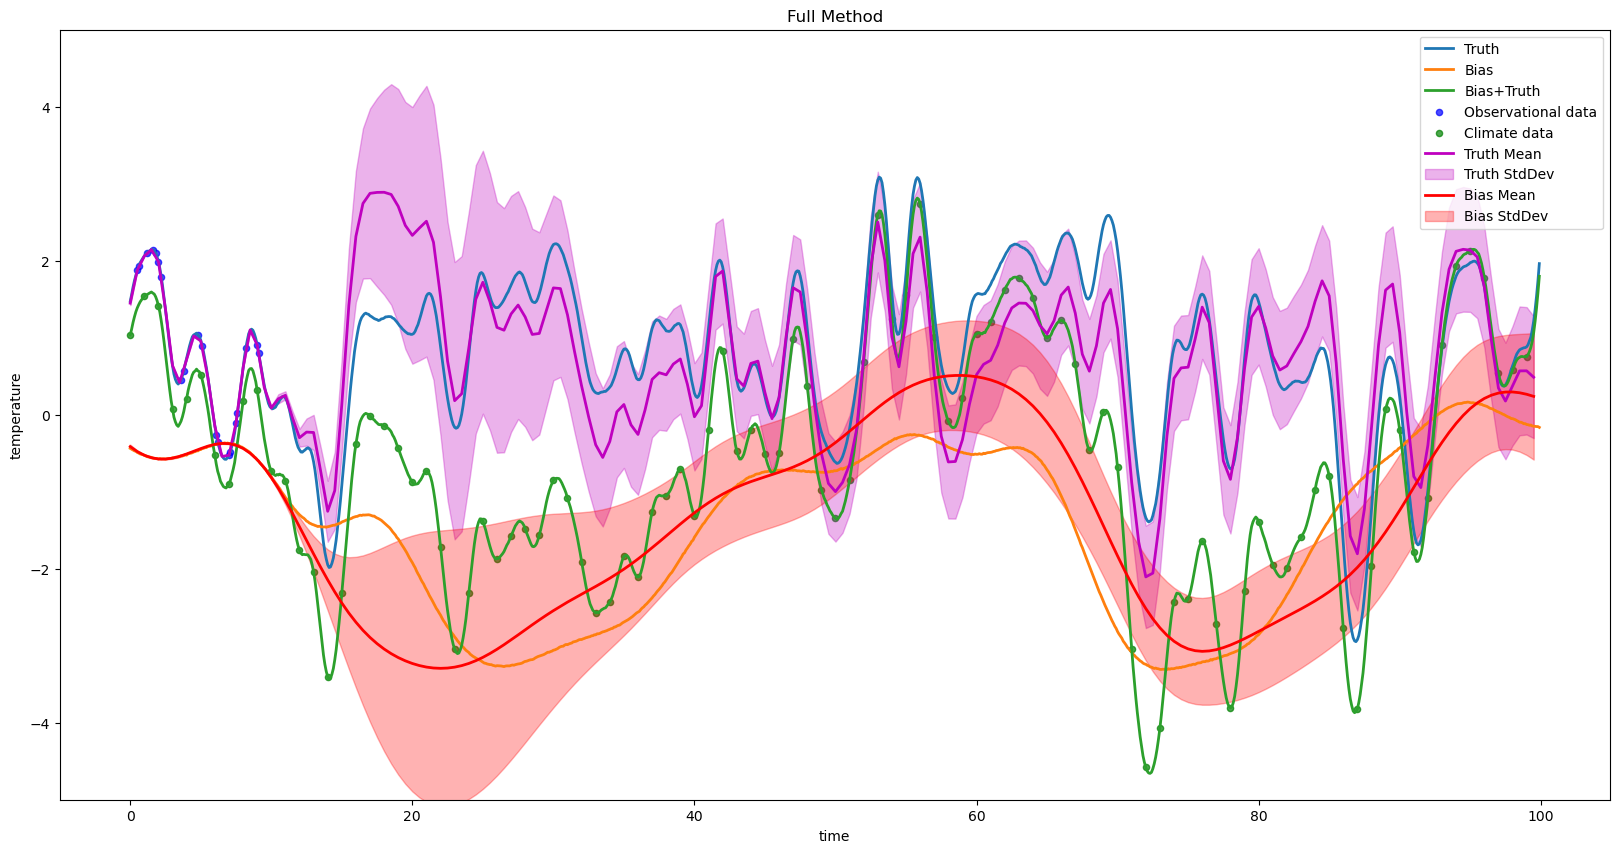

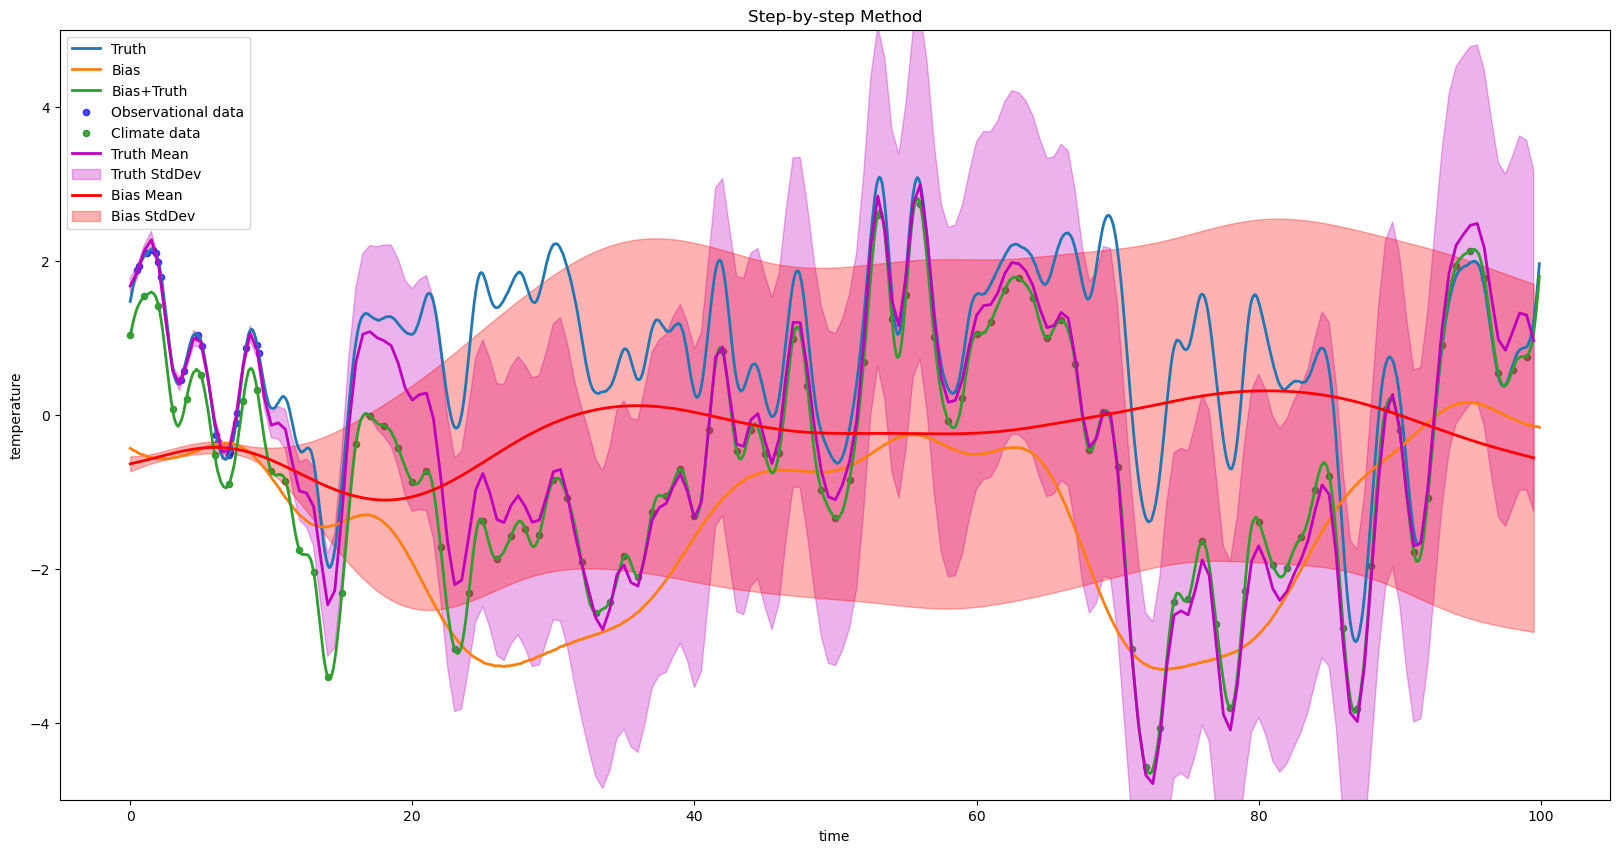

In [14]:
# Scenario: Different Lengthscales, Clustered Observations
onoise=1e-5
bnoise=1e-5
cnoise=1e-5
jitter=1e-5

GP = GaussianProcess(1 * kernels.ExpSquared(1),X,diag=onoise,mean=1.0)
Y = GP.sample(rng_key)

GP2 = GaussianProcess(1 * kernels.ExpSquared(5),X,diag=bnoise,mean=-1.0)
rng_key, rng_key_ = random.split(rng_key)
Y2 = GP2.sample(rng_key)

cx = X[::10] 
cdata = (Y+Y2)[::10] 
osample = np.random.choice(range(int(X.size *0.1)), size=int(0.2*cx.size), replace=False)
ox = X[osample]
odata = Y[osample]

plot_underlying_data(X,Y,Y2,ox,odata,cx,cdata,fs=(20,10),ms=20)

mcmc_2process = run_inference(
    tinygp_2process_model, rng_key_, 1000, 2000,
    cx,ox=ox,cdata=cdata,odata=odata,onoise=onoise,cnoise=cnoise)
idata_2process = az.from_numpyro(mcmc_2process)
nx = X[::5] # locations where predictions will be made

truth_realisations,bias_realisations = realisations_2process(
    nx,ox,cx,odata,cdata,idata_2process,onoise,cnoise,jitter,20,20)

plotting_output_2process(X,Y,Y2,ox,odata,cx,cdata,
                         truth_realisations,bias_realisations,nx,
                         fs=(20,10),ms=20,ylims=[-5,5])
plt.title('Full Method')

sbs_truth_realisations,sbs_bias_realisations = step_by_step_method(
    ox,odata,cx,cdata,cnoise,nx,20,20)

plotting_output_2process(X,Y,Y2,ox,odata,cx,cdata,
                         sbs_truth_realisations,sbs_bias_realisations,nx,
                         fs=(20,10),ms=20,ylims=[-5,5])
plt.title('Step-by-step Method')